In [2]:
%matplotlib notebook

import os
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
import subprocess
import shutil

from IPython.display import display, Image
# from EAZY_fun import *
from scipy import interpolate
from scipy import integrate
from astropy.io import ascii
from astropy.wcs import WCS
from matplotlib.ticker import AutoMinorLocator
from synphot import SourceSpectrum, etau_madau
from synphot.models import ConstFlux1D
from synphot.models import Empirical1D
import glob
#import sncosmo


In [3]:
way2 = 'goodss_3dhst.v4.1.cat'
way  = 'tweak_cosmos_v4/'
name = 'eazy_v1.1_sed'

In [4]:
# Load all model spectra and main catalog

list =  glob.glob(way + 'eazy*.dat')
main_cat = np.genfromtxt(way2, skip_header=2)  #[200:210]

In [5]:
main_cat.shape

(50507, 141)

In [6]:
# The column numbers of the flux in the main catalog

#flux_cat = [9,12,15,18,21,24,27,30,33,36,39,42,45,48,51,54,57,60,63,66,69,72,75,\
#           78,81,84,87,89,91,93,95,97,99,101,103,105,107,109,111,113]

fl1 = np.linspace(9, 87, 27)
fl2 = np.linspace(89, 113, 13)
num_fc = np.hstack((fl1, fl2))


# The column numbers of the errors in the main catalog

#error_flux_cat = [10,13,16,19,22,25,28,31,34,37,40,43,46,49,52,55,58,61,64,67,70,\
#                 73,76,79,82,85,88,90,92,94,96,98,100,102,104,106,108,110,112,114]
    
efl1 = np.linspace(10, 88, 27)
efl2 = np.linspace(90, 114, 13)
num_efc = np.hstack((efl1, efl2))


fil_cat = ['F160W', 'U38', 'U', 'F435', 'B', 'V', 'F606cand', 'F606W', 'R', 'Rc','F775W', 'I', 'F814Wcand',\
          'F850LP', 'F850LPcand', 'F125W', 'J', 'tenisJ', 'F140W', 'H', 'tenisK', 'Ks', 'IRAC1', \
          'IRAC2', 'IRAC3', 'IRAC4', 'IA427', 'IA445', 'IA505', 'IA527', 'IA550', 'IA574', 'IA598',\
          'IA624', 'IA651', 'IA679', 'IA738', 'IA767', 'IA797', 'IA856']

# Central wavelengths of filters

lambd = np.array(([1.5396, 0.3637, 0.3750, 0.4318, 0.4563, 0.5396, 0.5921, 0.5919, 0.6443, 0.6517,\
                   0.7693, 0.7838, 0.8057, 0.9036, 0.9033, 1.2471, 1.2356, 1.2530, \
                   1.3924, 1.6496, 2.1574, 2.1667, 3.5569, 4.5020, 5.7450, 7.9158, 0.4260, 0.4443, 0.5061, 0.5259,\
                   0.5495, 0.5763,  0.6007, 0.6231, 0.6498, 0.6782, 0.7359, 0.7680, 0.7966, 0.8565]))

print(lambd * 10 ** 4)
print(len(lambd))
print("")
print(len(fil_cat))
         

[ 15396.   3637.   3750.   4318.   4563.   5396.   5921.   5919.   6443.
   6517.   7693.   7838.   8057.   9036.   9033.  12471.  12356.  12530.
  13924.  16496.  21574.  21667.  35569.  45020.  57450.  79158.   4260.
   4443.   5061.   5259.   5495.   5763.   6007.   6231.   6498.   6782.
   7359.   7680.   7966.   8565.]
40

40


In [7]:
# The function of shifting the wavelength and shift amplitude of the flux 

def func_1(z, n, x, y):
    l_mod  = (1+z)*x
    mod_flux = n*y
    return l_mod, mod_flux

In [8]:
# !!! I am looking for a galaxy with spectroscopic redshift above 5
np.where(main_cat[:,-21]>5)
# main_cat[:,0][np.where(main_cat[:,-21]>5)]

(array([5646]),)

In [9]:
# Number of object 
id = 28684
id = 5646


print('Spectroscopic redshift: ', main_cat[id,-21])

# Cosmological constants

Omega_M = 0.2726             # Density of matter
Omega_K =  0.0               # Density of curvature
Omega_L = 0.7274             # Density of dark energy
h = 0.704

# For reference

c = 2.9927e10
pi = 3.14159265


# Collection of additional distance functions  

E   = lambda x: 1/np.sqrt(Omega_M*np.power(1+x,3)+Omega_L+Omega_K*np.power(1+x,2))
D_c = lambda x: (9.26e27/h)*integrate.quad(E, 0, x)[0]                                     # In centimeters
D_m = lambda x: D_c(x)
D_A = lambda x: D_m(x)/(1+x)
D_L = lambda x: np.power(1+x, 2) * D_A(x)

Spectroscopic redshift:  5.563


In [79]:
# A function that takes into account the absorption 
# It return  

def chi2(z, n, lcii, x, y, toplot=False):

    # Find the template corresponding to our z and n
    
    l_obs2, moh = func_1(z, n, x, y)

    lcii = np.array(lcii)
    
    # Sorting
    moh = moh[np.argsort(l_obs2)]
    l_obs2 = l_obs2[np.argsort(l_obs2)]
    lcii = lcii[np.argsort(lcii)]

    # Add the absorption for objects with a large redshift
    
    extcurve = etau_madau(l_obs2, z)
#     print(extcurve)
    sp_ext = moh * extcurve(l_obs2)

#     print(l_obs2, sp_ext)
    
    
    print('max', 'min', np.max(l_obs2), np.min(l_obs2))
    # Let`s compare two spectra, with and the absorption
    
    if toplot:
        plt.plot(l_obs2, sp_ext, 'r', lw =2)
#         plt.scatter(l_obs2, moh, s = 25, color='black')
        plt.xlabel('Wavelength (Angstrom)')
        plt.ylabel('Flux (nJy)')
#         plt.legend(['Original', 'Extincted'], loc='upper left', fontsize=15)
#         plt.xlim(0, 10000)
#         plt.ylim(0, 200)
        plt.show()
       
    

    # Interpolation
    #func = np.interp(lcii, l_obs2, moh)


    #return func
    return sp_ext, l_obs2, moh


In [11]:
#print(etau_madau([3000,4000,5000,6000], 5.)(63000))

In [12]:
# Spectrum from the catalog hst

flux_c = []
erflu_c = []
filt = []

for i in range(len(main_cat[0, :])):
    for j in range(len(num_fc)):
        if (i == num_fc[j]) & (main_cat[id - 1, i] > 0):
            flux_c.append(main_cat[id - 1, i])
            erflu_c.append(main_cat[id - 1, int(num_efc[j])])
            filt.append(j)

# Translate the wavelength into angstroms
lci = lambd[filt] * 10 ** 4

# Reproduce to a good type

flux_c = np.array(flux_c)
erflu_c = np.array(erflu_c)

# Translate the flow into nano Jansky

flux_c = [flux_c[i] * 10 ** (2.56) for i in range(len(flux_c))]
erflu_c = erflu_c * 10**2.56

# Reproduce to a good type again

flux_c = np.array(flux_c)
erflu_c = np.array(erflu_c)


In [13]:
# Sorting
flux_c = flux_c[np.argsort(lci)]
erflu_c = erflu_c[np.argsort(lci)]
lci = lci[np.argsort(lci)]

# Data from template
ntemplate = 0
x = np.genfromtxt(list[ntemplate])[:, 0]
y = np.genfromtxt(list[ntemplate])[:, 1]


In [15]:
# How many points we want for z and n

z_list = np.linspace(0,10,100)
n_list = np.logspace(-3,1,100)

# fib = chi(3, 1.6*10**58, lci, x, y)
# print(np.shape(fib), type(fib.value[1]))
# # У меня подозрения вызывают эти единицы. Поток я посылаю в наноянски, а здесь он выдает вообще нечто другое.
# # Влияет это как то на точность или нет?
# print(fib.unit) 

In [35]:
L = np.ones((len(n_list),len(z_list)))

# The main cycle
for i in range (len(n_list)):
    
    for j in range (len(z_list)):
#         print(i,j)
        fitz = chi2(z_list[j], n_list[i], lci, x, y)
        L[i,j] = np.mean((flux_c - fitz)**2/(erflu_c**2))
        
print("END")

END


In [68]:
'''
t = np.arange(1)
plt.figure(11)
plt.contourf(z_list, n_list, np.log10(L), c = t)
plt.yscale('log')

'''

'''
plt.figure(12)
plt.plot(z_list,(L.min(0)))
plt.xlabel('$z$')
plt.ylabel('$\chi^2$')
plt.show()
'''

'''
plt.figure(18)
plt.plot(z_list,np.exp(-L.min(0))+1e-50)
plt.xlabel('$z$')
plt.ylabel('$p(z)$')
plt.yscale("log")
plt.show()
'''


"\nt = np.arange(1)\nplt.figure(11)\nplt.contourf(z_list, n_list, np.log10(L), c = t)\nplt.yscale('log')\n\n"

In [16]:
fname = 'goodss_3dhst.v4.1.translate'
filt_list = np.genfromtxt(fname, dtype=None)

fil = []
num_fil = []
for i, j in  zip(filt_list[:,1], np.linspace(0,87,88)):
    if j%2==0:
        num_fil.append(np.array(i[1:]).astype(int))
    #print(np.array(i[1:]).astype(int))        

    
for i, j in  zip(filt_list[:,0], np.linspace(0,87,88)):
    if j%2==0:
        fil.append(np.array(i[2:]).astype(str))
    #print(np.array(i[1:]).astype(int))        
   
 
num_fil = np.array(num_fil)
fil = np.array(fil)

# Filters and their numbers
fil = fil[np.argsort(num_fil)]
num_fil = num_fil[np.argsort(num_fil)]

In [17]:
# Delete filters that are not in the article

hi = [19,20,29,33]
print(np.delete(num_fil,hi))
print(np.delete(fil, hi))

[  1   4   5   7  18  19  20  21  34  36  37  46  50  54  58 103 107 181
 182 185 186 187 188 189 190 191 192 194 195 196 198 203 204 205 220 222
 236 239 240 260]
['F435W' 'F606W' 'F775W' 'F850LP' 'IRAC1' 'IRAC2' 'IRAC3' 'IRAC4' 'J' 'H'
 'Ks' 'B' 'V' 'Rc' 'I' 'U' 'U38' 'IA427' 'IA445' 'IA505' 'IA527' 'IA550'
 'IA574' 'IA598' 'IA624' 'IA651' 'IA679' 'IA738' 'IA767' 'IA797' 'IA856'
 'F125W' 'F140W' 'F160W' 'tenisJ' 'tenisK' 'F606Wcand' 'F814Wcand'
 'F850LPcand' 'R']


In [19]:
# All filters

filters_info = []
for line in open('FILTER.RES.latest.info', 'r'):
    filters_info.append(np.array(line.split()))
filters_info = np.array(filters_info)
print(filters_info[0])

['1' 'hst/ACS_update_sep07/wfc_f435w_t77.dat' 'obs_before_7-4-06+rebin-5A'
 'lambda_c=' '4.3179e+03' 'AB-Vega=-0.104' 'w95=993.1']


In [46]:
temp_filters = open('FILTER.RES.latest', 'r')
filters = []
filters_names = []
first = True

l = 0
for line in temp_filters:
    
    if line[0] == ' ':
        
        if not first:
            filters.append(np.array(temp))
            l+=1
            
        first = False
        filters_names.append(line.split())
        temp = []
      
    else:
        temp.append(np.array(line.split()).astype('float'))


# filters - include response function for each filter
# filters_name - include all filters name

print(filters_names[4])

['86', 'hst/ACS_update_sep07/wfc_f775w_t77.dat', 'obs_before_7-4-06+rebin-5A', 'lambda_c=', '7.6933e+03', 'AB-Vega=', '0.385', 'w95=1490.9']


In [47]:
filters = np.array(filters)
filters_names = np.array(filters_names)
#filters_names[np.array([a[0] for a in filters_names]).astype(int) == 236] -- what 

print(np.shape(filters[0]))
print(np.shape(filters))
print(filters_names[4])

(133, 3)
(306,)
['86', 'hst/ACS_update_sep07/wfc_f775w_t77.dat', 'obs_before_7-4-06+rebin-5A', 'lambda_c=', '7.6933e+03', 'AB-Vega=', '0.385', 'w95=1490.9']


In [48]:
# It return name and response function for each filter by id in num_fil

def get_filter_by_id(id):
    
    temp = np.array([a[0] for a in filters_info]).astype(int)
    name = filters_info[np.where(temp==id)[0][0]][1]
    names = np.array([a[1] for a in filters_names])
#   print name
    return filters[np.where(name == names)[0][0]], name




In [129]:
print(len(tem_fl), len(tem_lam))
print(max(tem_lam), min(tem_lam))

2818 2818
4800000.0 273.0


In [131]:
print('x_temp')
x_tem = tem_lam[np.where( (tem_lam>=min(res[:,1])) & (tem_lam<=max(res[:,1])))[0]]
print(x_tem)
print('y_temp')
y_tem = tem_fl[np.where( (tem_lam>=min(res[:,1])) & (tem_lam<=max(res[:,1])))[0]]
print(y_tem)


x_temp
[ 4605.  4635.  4665.  4695.  4725.  4755.  4785.  4815.  4845.  4875.
  4905.  4935.  4965.  4995.  5016.  5031.  5055.  5085.  5115.  5145.
  5175.  5205.  5235.  5265.  5295.  5325.  5355.  5385.  5415.  5445.
  5475.  5505.  5535.  5565.  5595.  5625.  5655.  5685.  5715.  5745.
  5775.  5805.  5835.  5865.  5901.  5928.  5952.  5985.  6015.  6045.
  6075.  6105.  6135.  6165.  6195.  6222.  6234.  6255.  6285.  6315.
  6345.  6375.  6405.  6435.  6465.  6495.  6525.  6555.  6585.  6615.
  6645.  6675.  6705.  6735.  6765.  6795.  6825.  6855.  6885.  6915.
  6945.  6975.  7005.  7035.  7065.  7095.  7125.  7155.]
y_temp
[ 4.09995  3.99251  3.99179  4.16901  4.36288  4.49665  4.55957  4.5301
  4.53429  4.53108  4.64568  4.68484  4.68528  4.8093   4.69055  4.98203
  5.03859  4.93622  4.86948  4.79412  4.80328  4.93923  4.94995  5.0308
  4.91137  4.94666  5.02766  5.16317  5.19319  5.07953  5.07765  5.01864
  4.83104  4.87879  5.0005   5.07286  4.94585  4.90664  4.95752  4.901

<IPython.core.display.Javascript object>


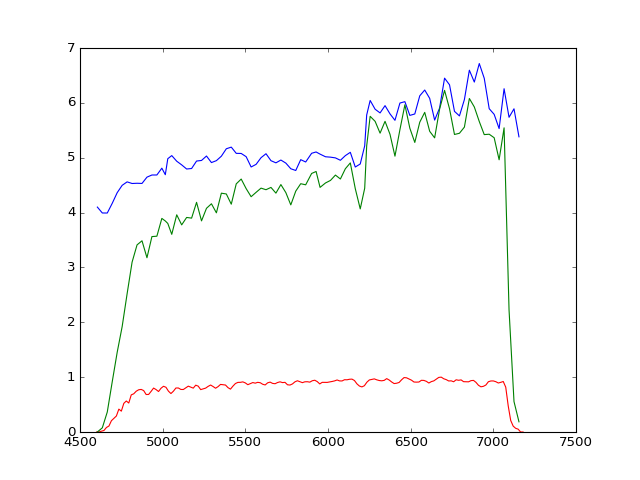

In [142]:
# Response, template, result
func = np.interp(x_tem, x_res, y_res)
plt.figure(11)
plt.plot(x_res, y_res, 'r')
plt.plot(x_tem, y_tem, 'b')
plt.plot(x_tem, y_tem*func, 'g')
plt.show()

In [130]:
res, n = get_filter_by_id(4)
print(n)
print(max(res[:,1]), min(res[:,1]))
print('x_res')
x_res = res[:,1]
print(x_res)
print('y_res')
y_res = res[:,2]
print(y_res)


hst/ACS_update_sep07/wfc_f606w_t77.dat
7180.0 4600.0
x_res
[ 4600.  4615.  4630.  4645.  4660.  4675.  4690.  4705.  4720.  4735.
  4750.  4765.  4780.  4795.  4810.  4825.  4840.  4855.  4870.  4885.
  4900.  4915.  4930.  4945.  4960.  4975.  4990.  5005.  5020.  5035.
  5050.  5065.  5080.  5095.  5110.  5125.  5140.  5155.  5170.  5185.
  5200.  5215.  5230.  5245.  5260.  5275.  5290.  5305.  5320.  5335.
  5350.  5365.  5380.  5395.  5410.  5425.  5440.  5455.  5470.  5485.
  5500.  5515.  5530.  5545.  5560.  5575.  5590.  5605.  5620.  5635.
  5650.  5665.  5680.  5695.  5710.  5725.  5740.  5755.  5770.  5785.
  5800.  5815.  5830.  5845.  5860.  5875.  5890.  5905.  5920.  5935.
  5950.  5965.  5980.  5995.  6010.  6025.  6040.  6055.  6070.  6085.
  6100.  6115.  6130.  6145.  6160.  6175.  6190.  6205.  6220.  6235.
  6250.  6265.  6280.  6295.  6310.  6325.  6340.  6355.  6370.  6385.
  6400.  6415.  6430.  6445.  6460.  6475.  6490.  6505.  6520.  6535.
  6550.  6565.  65